# 03-201 : Unbalanced Per Question

Before trying to balance the data, experiment with creating models per question which was not done in the previous notebook.

## Web References

- [How to compute f1 score for each epoch in Keras](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2)


In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import sys
import logging
from typing import Tuple
import copy

import pandas as pd

import mlflow
import mlflow.keras

import tensorflow as tf
import tensorflow_addons as tfa

from competition import source_data as sd
from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import model_training as mt
from competition import model_layers as ml
from competition import model_definitions as mm

import seaborn as sns
import matplotlib.pyplot as plt

### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-27 15:48:12 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Exploratory Data Analysis

In [8]:
df_source_labels.head()

,session_id,question_num,correct,level_group
0,20090312431273200,1,1,0-4
1,20090312433251036,1,0,0-4
2,20090314121766812,1,1,0-4
3,20090314363702160,1,1,0-4
4,20090314441803444,1,1,0-4


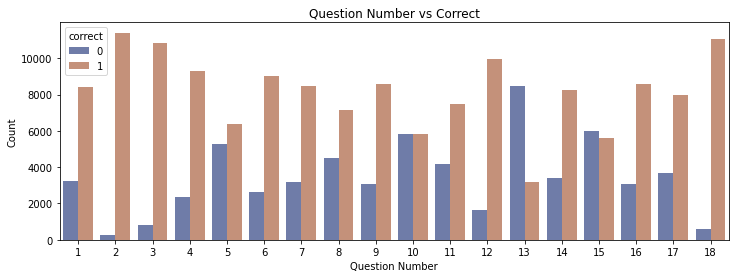

In [9]:
plt.figure(figsize=(12, 4))
g = sns.countplot(
    data=df_source_labels,
    x='question_num',
    hue='correct',
    palette='dark',
    alpha=.6)

g.set_xlabel('Question Number')
g.set_ylabel('Count')
g.set_title('Question Number vs Correct')

plt.show()

This plot closely reflects the `simple_monkey` approach where we simply used a constant array instead of a model.

```
[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
```

- When training for the individual questions, start with the questions with `0` in the array.

- Question `5`, `10`, and `15` have especially close splits. So can potentially lead improved results when building seperate models for them while still using a constant answer for the other questions .

In [10]:
# Calculate the percentage of correct vs. incorrect answers for each question_num
question_counts = df_source_labels.groupby(['question_num', 'correct']).size().unstack(fill_value=0)
question_percentages = question_counts.div(question_counts.sum(axis=1), axis=0) * 100
question_percentages.columns.name = None

# Display the resulting DataFrame
with pd.option_context("display.float_format", "{:.2f}".format):
    display(question_percentages)

,0,1
question_num,,
1,27.58,72.42
2,2.10,97.90
3,6.78,93.22
4,20.09,79.91
5,45.31,54.69
6,22.75,77.25
7,27.09,72.91
8,38.60,61.40
9,26.40,73.60


## Feature Engineering

In [11]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

In [12]:
# add the feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

In [13]:
# add the total count features to the features dataset
df_features = fe.add_count_total_features(
    features=df_features,
    X=df_source)

In [14]:
# add the unique count features to the features dataset
df_features = fe.add_count_unique_features(
    features=df_features,
    X=df_source)

In [15]:
with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.000000,0.525424,0.545455,0.675
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.000000,0.355932,0.454545,0.400
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075
4,20090312433251036,13-22,0.324157,1.000000,0.318718,0.676403,1.000000,1.000000,1.000000,1.000000,1.000000,0.585056,1.00,1.000000,0.932203,0.909091,0.875
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301,0.364727,0.364727,0.400646,0.364727,0.238474,1.00,0.333333,0.457627,0.454545,0.350


## Data Selection

We first combine the features with the labels as we will do data selection now based on question number as opposed to to all previous notebooks.

In [16]:
df_combined = df_source_labels.merge(
    right=df_features, 
    on=['session_id', 'level_group'],
    how='left')

print(df_combined.shape)
with pd.option_context('display.max_columns', None):
    display(df_combined.head(6))

(209664, 19)


,session_id,question_num,correct,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid
0,20090312431273200,1,1,0-4,0.001411,0.052535,0.0,0.023103,0.0,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225
1,20090312433251036,1,0,0-4,0.001352,0.063074,0.0,0.026311,0.0,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075
2,20090314121766812,1,1,0-4,0.002928,0.106324,0.0,0.047996,0.0,0.088782,0.088782,0.066236,0.088782,0.044515,1.00,0.333333,0.135593,0.090909,0.175
3,20090314363702160,1,1,0-4,0.001627,0.058690,0.0,0.030143,0.0,0.065987,0.065987,0.050081,0.065987,0.034976,0.50,0.000000,0.050847,0.090909,0.075
4,20090314441803444,1,1,0-4,0.000824,0.047682,0.0,0.020862,0.0,0.019196,0.019196,0.025848,0.019196,0.022258,0.50,0.000000,0.067797,0.090909,0.050
5,20090315081004164,1,0,0-4,0.002515,0.092231,0.0,0.036151,0.0,0.116377,0.116377,0.096931,0.116377,0.063593,0.75,0.000000,0.118644,0.090909,0.150


Create a function that will combine the datasets like we just did above and then return the dataset for the specified question.

In [17]:
def get_question_dataset(features: pd.DataFrame,
                         labels: pd.DataFrame,
                         question_num: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns a dataset containing only the specified question_num.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset with prepared and normalized data.
    labels : pd.DataFrame
        The labels dataset containing the target variable.
    question_num : int
        The question number to filter on.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        The filtered features and labels datasets.
    """
    # combine the features and labels datasets
    df_combined = labels.merge(
        right=features, 
        on=['session_id', 'level_group'],
        how='left')

    # filter the combined dataset on the specified question_num
    df_question = df_combined[df_combined['question_num'] == question_num]

    # split the combined dataset into features and labels again
    df_question_features = df_question \
        .drop(columns=['question_num', 'correct']) \
        .drop_duplicates()

    df_question_labels = df_question[['session_id', 'question_num', 
                                     'correct', 'level_group']]
    
    # return the filtered features and labels datasets
    return df_question_features, df_question_labels

# test the function
df_question_features, df_question_labels = get_question_dataset(features=df_features,
                                                                labels=df_source_labels,
                                                                question_num=5)

Split the data into training and test sets.

In [18]:
random_state = 51

In [19]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_question_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [20]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
simple_model_dataset = md.get_feature_dataset(
    features=df_question_features,
    y=df_question_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-03-27 15:49:36 INFO     -- Creating the train dataset
2023-03-27 15:49:36 INFO     Creating the dataset for all level groups


  0%|          | 0/3495 [00:00<?, ?it/s]

2023-03-27 15:49:45 INFO     -- Creating the val dataset
2023-03-27 15:49:45 INFO     Creating the dataset for all level groups


  0%|          | 0/1165 [00:00<?, ?it/s]

2023-03-27 15:49:48 INFO     -- Creating the test dataset
2023-03-27 15:49:48 INFO     Creating the dataset for all level groups


  0%|          | 0/6988 [00:00<?, ?it/s]

In [21]:
# define the simple model input shape
input_data = simple_model_dataset['train']['X']
simple_model_shape = input_data.shape[1]
print('simple_model_shape:', simple_model_shape)

# define the output shape
output_data = simple_model_dataset['train']['y']
simple_model_output_shape = 1
print('output_shape', simple_model_output_shape)

simple_model_shape: 23
output_shape 1


In [22]:
# configure mlflow
mlflow.set_experiment("initial-question-05")
mlflow.keras.autolog()

2023-03-27 15:50:09 INFO     Creating simple dense model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 1024)              24576     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,075,201
Trainable params: 1,075,201
Non-trainable params: 0
_________________________________________________________________


2023-03-27 15:50:09.831278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-03-27 15:50:09.831316: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 15:50:09.831336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lena): /proc/driver/nvidia/version does not exist
2023-03-27 15:50:09.831677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropr

Epoch 1/300
4/4 [==============================] - 1s 141ms/step - loss: 0.9769 - accuracy: 0.5465 - val_loss: 0.9560 - val_accuracy: 0.5459
Epoch 2/300
4/4 [==============================] - 0s 39ms/step - loss: 0.9446 - accuracy: 0.5574 - val_loss: 0.9278 - val_accuracy: 0.5433
Epoch 3/300
4/4 [==============================] - 0s 41ms/step - loss: 0.9147 - accuracy: 0.5545 - val_loss: 0.9018 - val_accuracy: 0.5442
Epoch 4/300
4/4 [==============================] - 0s 37ms/step - loss: 0.8878 - accuracy: 0.5611 - val_loss: 0.8764 - val_accuracy: 0.5519
Epoch 5/300
4/4 [==============================] - 0s 41ms/step - loss: 0.8630 - accuracy: 0.5611 - val_loss: 0.8531 - val_accuracy: 0.5536
Epoch 6/300
4/4 [==============================] - 0s 40ms/step - loss: 0.8392 - accuracy: 0.5745 - val_loss: 0.8317 - val_accuracy: 0.5579
Epoch 7/300
4/4 [==============================] - 0s 39ms/step - loss: 0.8180 - accuracy: 0.5797 - val_loss: 0.8126 - val_accuracy: 0.5519
Epoch 8/300
4/4 [==

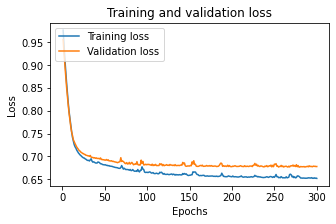

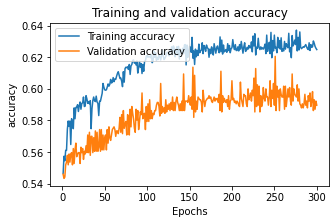

146/146 [==============================] - 0s 2ms/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

           0       0.61      0.36      0.45      3157
           1       0.60      0.81      0.69      3831

    accuracy                           0.61      6988
   macro avg       0.61      0.58      0.57      6988
weighted avg       0.61      0.61      0.58      6988

```

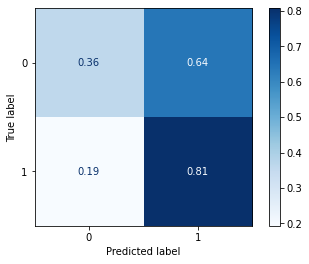

#### Optimal Threshold: 0.58
```
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      3157
           1       0.63      0.65      0.64      3831

    accuracy                           0.60      6988
   macro avg       0.60      0.60      0.60      6988
weighted avg       0.60      0.60      0.60      6988

```

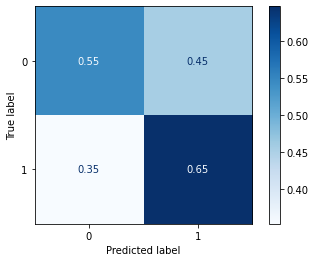

2023/03/27 15:50:50 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/03/27 15:50:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


2023-03-27 15:50:50 WARNING  Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/tmprm8769nq/model/data/model/assets
2023-03-27 15:50:50 INFO     Assets written to: /tmp/tmprm8769nq/model/data/model/assets


In [23]:
# log the parameters
mlflow.set_tag('model', 'simple-dense-model')
mlflow.set_tag('notebook', '03-201')
mt.log_params(simple_model_dataset, feature_list, random_state)

# train the model
model = mm.train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=2,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=1e-5,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,
    train_epochs=300,
    train_batch_size=1000,
    train_optimizer='adam',
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

mlflow.end_run()

### F1 Metric

Revist the F1 metric and see if we can  get closer to the macro as calculated by the `sklearn` function.

In [24]:
simple_model_dataset['train']['y']

array([0, 1, 0, ..., 0, 0, 0], dtype=int8)

In [25]:
simple_model_dataset['train']['y'].shape

(3495,)

In [26]:
tf.keras.utils.to_categorical(simple_model_dataset['train']['y'])


array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [34]:
def label_to_categorical(dataset:dict) -> dict:
    """
    Converts the labels to a categorical values.
    """
    new_dataset = copy.deepcopy(dataset)
    for key in dataset.keys():
        new_dataset[key]['y'] = tf.keras.utils.to_categorical(new_dataset[key]['y'], num_classes=2)

    return new_dataset

# convert the labels to categorical values
cat_simple_model_dataset = label_to_categorical(simple_model_dataset)
cat_simple_model_dataset['train']['y'].shape


(3495, 2)

2023-03-27 16:38:15 INFO     Creating simple dense model
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 23)]              0         
                                                                 
 dense_51 (Dense)            (None, 1024)              24576     
                                                                 
 dense_52 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_53 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 1,076,226
Trainable params: 1,076,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 1s 88ms/step - loss: 0.9748 - f1_score: 0.4847 - val_loss: 0.9538 - val_f

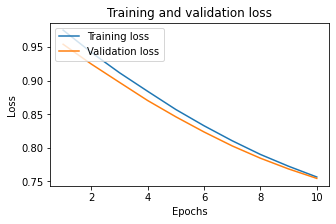

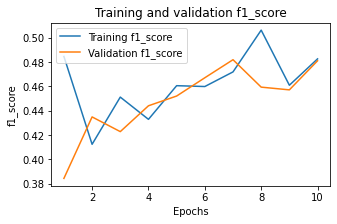

146/146 [==============================] - 0s 2ms/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

         0.0       0.57      0.20      0.29      3157
         1.0       0.57      0.87      0.69      3831

    accuracy                           0.57      6988
   macro avg       0.57      0.54      0.49      6988
weighted avg       0.57      0.57      0.51      6988

```

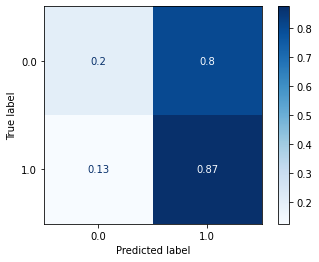

#### Optimal Threshold: 0.55
```
              precision    recall  f1-score   support

         0.0       0.52      0.49      0.50      3157
         1.0       0.60      0.62      0.61      3831

    accuracy                           0.56      6988
   macro avg       0.56      0.56      0.56      6988
weighted avg       0.56      0.56      0.56      6988

```

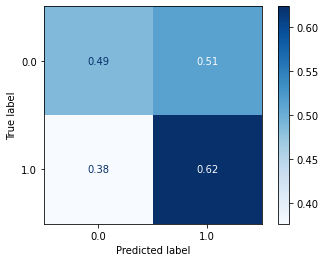

2023/03/27 16:38:19 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/03/27 16:38:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


2023-03-27 16:38:20 WARNING  Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/tmpyf1yzokt/model/data/model/assets
2023-03-27 16:38:20 INFO     Assets written to: /tmp/tmpyf1yzokt/model/data/model/assets


2023/03/27 16:38:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpyf1yzokt/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback.


In [51]:
# log the parameters
mlflow.set_tag('model', 'simple-dense-model')
mlflow.set_tag('notebook', '03-101_mlflow.ipynb')
mt.log_params(simple_model_dataset, feature_list, random_state)

# train the model
model = mm.train_simple_dense(
    dataset=cat_simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=2,
    dense_layer_count=2,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=1e-5,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,
    train_epochs=10,
    train_batch_size=1000,
    train_optimizer='adam',
    train_loss='binary_crossentropy',
    train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')],
    train_class_weight=None)

mlflow.end_run()

In [ ]:
y_true = simple_model_dataset['val']['y']
y_pred = model.predict(simple_model_dataset['val']['X'])

# show the classification report
print(classification_report(y_true, y_pred.round()))